/Users/pl771/Devel/MRINeedleSegmentation/TestingNotebook/TissueBase_M.nii.gz
(1, 192, 192, 16)


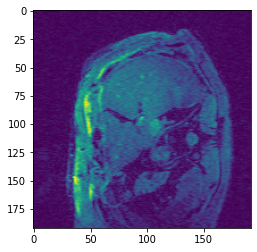

In [15]:
import glob
import os

import tempfile
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Any, Mapping, Hashable

import monai
from monai.config import print_config
from monai.utils import first
from monai.config import KeysCollection
from monai.data import Dataset, ArrayDataset, create_test_image_3d, DataLoader
from monai.transforms import (
    Transform,
    Compose,
    EnsureChannelFirst,
    LoadImage,
    Orientation,
)

#### SELECT IMAGE TESTING SET
base = 'TissueBase'     # AXIAL
# base = 'PhantomBase'  # CORONAL

# Define orientation for rotation
axcode = 'RAS'
if base == 'TissueBase':
    # axcode = 'PLS'
    axcode = 'LPS'
elif base =='PhantomBase':
    axcode = 'ILP'
    
    
srcdir = os.getcwd()

# Load images
print(os.path.join(srcdir, base+'_M'+'.nii.gz'))
images_m = sorted(glob.glob(os.path.join(srcdir, base+'_M'+'.nii.gz')))
images_p = sorted(glob.glob(os.path.join(srcdir, base+'_P'+'.nii.gz')))
labels = sorted(glob.glob(os.path.join(srcdir, base+'_label'+'.nii.gz')))

# Create dictionary
train_files = [
    {'image': image_name, 'label': label_name}
    for image_name, label_name in zip(images_m, labels)
]
img_file = train_files[0]['image']
label_file = train_files[0]['label']
fn_keys = ('image', 'label')  # filename keys for image and seg files

# Define transform
transfTest = Compose([LoadImage(image_only=True),
                EnsureChannelFirst(channel_dim='no_channel'), # This replaces deprecated AddChannel()
                Orientation(axcodes=axcode),
                ])
img = transfTest(img_file)
img_arr = np.array(img)
print(np.shape(img_arr))

sliceIndex = 0
plt.imshow(img[0,:,:,sliceIndex])
# plt.imshow(img[0,sliceIndex,:,:]) # channel, depth, height, width
